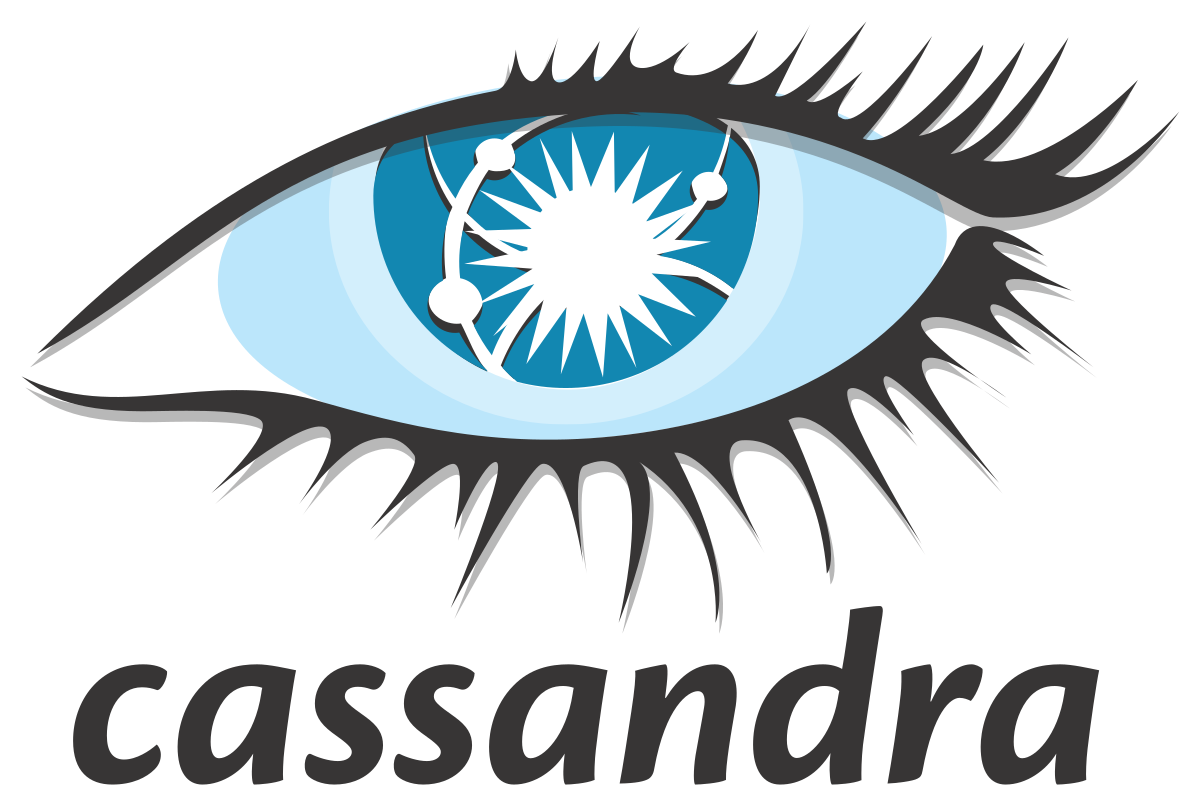

Esta hoja muestra cómo acceder a bases de datos Cassandra y también a conectar la salida con Jupyter.

Con Cassandra vamos a simular un modo semi-clúster con una sola máquina.

## Instalación de Apache Cassandra

Descargamos el ejecutable comprimido desde su página oficial

In [1]:
!wget https://dlcdn.apache.org/cassandra/4.1.4/apache-cassandra-4.1.4-bin.tar.gz

--2024-04-10 14:13:03--  https://dlcdn.apache.org/cassandra/4.1.4/apache-cassandra-4.1.4-bin.tar.gz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50342501 (48M) [application/x-gzip]
Saving to: ‘apache-cassandra-4.1.4-bin.tar.gz’

apache-cassandra-4. 100%[===================>]  48.01M   162MB/s    in 0.3s    

2024-04-10 14:13:03 (162 MB/s) - ‘apache-cassandra-4.1.4-bin.tar.gz’ saved [50342501/50342501]



In [2]:
!gpg --print-md SHA256 apache-cassandra-4.1.4-bin.tar.gz

gpg: directory '/root/.gnupg' created
gpg: keybox '/root/.gnupg/pubring.kbx' created
apache-cassandra-4.1.4-bin.tar.gz: 03447F95 8339BA70 F717CF2C F2FD97BE 17876540
                                   526A8634 3DB635A8 CA523BCD


Descomprimimos el archivo descargado

In [3]:
!tar xzf apache-cassandra-4.1.4-bin.tar.gz && echo OK!

OK!


Si vemos la configuración por defecto de nuestra instalacion de Cassandra, vemos que por defecto los indices SASI están desactivados.

In [4]:
!grep 'sasi_indexes_enabled' apache-cassandra-4.1.4/conf/cassandra.yaml

sasi_indexes_enabled: false


Activamos los índices SASI.

In [5]:
!sed -i 's/sasi_indexes_enabled: false/sasi_indexes_enabled: true/g' apache-cassandra-4.1.4/conf/cassandra.yaml

Ahora vemos que los SASIIndex están activados en nuestra configuración de Cassandra.

In [6]:
!grep 'sasi_indexes_enabled' apache-cassandra-4.1.4/conf/cassandra.yaml

sasi_indexes_enabled: true


Arracamos la base de datos (el parámetro `-R` nos permite hacerlo con el usuario `root`).

In [7]:
!(cd apache-cassandra-4.1.4/ && bin/cassandra -R)

OpenJDK 64-Bit Server VM warning: Option UseConcMarkSweepGC was deprecated in version 9.0 and will likely be removed in a future release.
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.deserializeLargeSubset(Lorg/apache/cassandra/io/util/DataInputPlus;Lorg/apache/cassandra/db/Columns;I)Lorg/apache/cassandra/db/Columns;
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubset(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;ILorg/apache/cassandra/io/util/DataOutputPlus;)V
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubsetSize(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;I)I
CompileCommand: dontinline org/apache/cassandra/db/commitlog/AbstractCommitLogSegmentManager.advanceAllocatingFrom(Lorg/apache/cassandra/db/commitlog/CommitLogSegment;)V
CompileCommand: dontinline org/apache/cassandra/db/transform/BaseIterator.tryGetMoreContents()Z
CompileCommand: dontinline org/apache/c

Con el comando `nodetool status`podemos ver que nuestro cluster contiene un unico datacenter, con un único host.

In [8]:
!apache-cassandra-4.1.4/bin/nodetool status

Datacenter: datacenter1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address    Load        Tokens  Owns (effective)  Host ID                               Rack 
UN  127.0.0.1  104.39 KiB  16      100.0%            738ff4a7-917e-4645-aa11-dedaec38e74a  rack1



Si quisieramos abrir la shell de comandos de Cassandra para ejecutar instrucciones directamente sobre ella deberíamos ejecutar el siguiente comando.

*De todas formas, dejamos la celda comentada puesto que nuestro interés es en acceder a la BD mediante Python*

In [9]:
#!apache-cassandra-4.1.4/bin/cqlsh

## Acceso a Cassandra mediante Python

Instalamos la librería `cassandra-driver` que nos dará acceso a nuestra instancia de Cassandra.

In [10]:
%pip install cassandra-driver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 37.6 MB/s eta 0:00:00


Nos conectamos al cluster de la BBDD especificando un único `ExecutionProfile`.

*A modo informativo, dejamos comentado el código de necesario para crear un segundo perfil de ejecución `node2_profile`*

In [11]:
from cassandra.cluster import Cluster
from cassandra.cluster import ExecutionProfile
from cassandra.policies import WhiteListRoundRobinPolicy

node1_profile = ExecutionProfile(load_balancing_policy=WhiteListRoundRobinPolicy(['127.0.0.1']))
#node2_profile = ExecutionProfile(load_balancing_policy=WhiteListRoundRobinPolicy(['127.0.0.2']))

profiles = {'node1': node1_profile}#, 'node2': node2_profile}
session = Cluster(execution_profiles=profiles, protocol_version=5).connect()

### Creación de espacios de nombres y tablas

Vamos a crear ahora un `keyspace` llamado `ciclismo`que vamos a usar posteriormente para definir una tabla sobre ciclistas.

In [12]:
resultado=session.execute("""
    CREATE KEYSPACE IF NOT EXISTS ciclismo
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}
""")

print(resultado)

Vamos ahora a crear una tabla `ciclistas`

In [13]:
session.execute("""CREATE TABLE IF NOT EXISTS ciclismo.ciclistas (
  id int,
  nombre text,
  apellidos text,
  edad int,
  equipo text,
  pais text,
  fecha_alta date,
  PRIMARY KEY (id));
  """);

### Creación de índices

Vamos a crear diferentes índices secundarios (no de tipo SASI) sobre algunos de los campos que hemos definido en la tabla `ciclistas`. Por ejemplo, vamos a definir uno sobre el campo `edad` y otro sobre el campo `fecha_alta` de esta forma.

In [14]:
session.execute("""
        CREATE INDEX ON ciclismo.ciclistas (edad);
""");

session.execute("""
        CREATE INDEX ON ciclismo.ciclistas (fecha_alta);
""");

Puesto que los tenemos activados, también podemos crear un SASIIndex sobre los campos `apellidos` y `pais`.

Es importante ver el mensaje de `WARNING` que nos devuelve la base de datos sobre el caracter experimental que tienen dichos índices en la versión 4.1 de Cassandra.

In [15]:
session.execute("""
        CREATE CUSTOM INDEX apellidos_index ON ciclismo.ciclistas (apellidos)
        USING 'org.apache.cassandra.index.sasi.SASIIndex'
        WITH OPTIONS = {
          'analyzer_class': 'org.apache.cassandra.index.sasi.analyzer.StandardAnalyzer',
          'tokenization_enable_stemming': 'false',
          'tokenization_locale': 'en'
        };
""");

session.execute("""
        CREATE CUSTOM INDEX pais_index ON ciclismo.ciclistas (pais)
        USING 'org.apache.cassandra.index.sasi.SASIIndex'
        WITH OPTIONS = {
          'analyzer_class': 'org.apache.cassandra.index.sasi.analyzer.StandardAnalyzer',
          'tokenization_enable_stemming': 'false',
          'tokenization_locale': 'en'
        };
""");

### Inserción de datos

Vamos ahora a insertar 20 ciclistas sobre la base de datos con la instruccion `INSERT INTO`

*¿Cuantos personajes de películas conoces? :-P*

In [16]:
from datetime import date

# Lista de datos de ejemplo para inserción
data = [
    (1, 'Luke', 'Skywalker', 25, 'Rebels', 'Tatooine', date(1980, 5, 25)),
    (2, 'Leia', 'Organa', 23, 'Rebels', 'Alderaan', date(1977, 5, 25)),
    (3, 'Han', 'Solo', 30, 'Rebels', 'Corellia', date(1977, 5, 25)),
    (4, 'Indiana', 'Jones', 35, 'Archaeologists', 'USA', date(1981, 6, 12)),
    (5, 'Ellen', 'Ripley', 30, 'Weyland-Yutani', 'USA', date(1979, 5, 25)),
    (6, 'Marty', 'McFly', 17, 'Hill Valley High School', 'USA', date(1985, 7, 3)),
    (7, 'Doc', 'Brown', 65, 'Scientist', 'USA', date(1985, 7, 3)),
    (8, 'Sarah', 'Connor', 29, 'Resistance', 'USA', date(1984, 10, 26)),
    (9, 'John', 'Connor', 10, 'Resistance', 'USA', date(1991, 7, 3)),
    (10, 'Hermione', 'Granger', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (11, 'Harry', 'Potter', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (12, 'Ron', 'Weasley', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (13, 'Neo', '', 30, 'The One', 'Unknown', date(1999, 3, 31)),
    (14, 'Trinity', '', 27, 'The One', 'Unknown', date(1999, 3, 31)),
    (15, 'Morpheus', '', 45, 'The One', 'Unknown', date(1999, 3, 31)),
    (16, 'Fox', 'Mulder', 35, 'FBI', 'USA', date(1993, 9, 10)),
    (17, 'Dana', 'Scully', 32, 'FBI', 'USA', date(1993, 9, 10)),
    (18, 'Ross', 'Geller', 30, 'Paleontologist', 'USA', date(1994, 9, 22)),
    (19, 'Rachel', 'Green', 29, 'Fashion', 'USA', date(1994, 9, 22)),
    (20, 'Chandler', 'Bing', 29, 'Advertising', 'USA', date(1994, 9, 22))
]

# Insertar los datos en la tabla ciclistas
for row in data:
    session.execute(
        """
        INSERT INTO ciclismo.ciclistas (id, nombre, apellidos, edad, equipo, pais, fecha_alta)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        """,
        row
    );

print("Se han insertado las filas correctamente.")

Se han insertado las filas correctamente.


### Consultas de selección

Vamos ahora a lanzar algunas consultas para hacer determinadas búsquedas sobre la base de datos.

En primer lugar, vamos a selecciona todos los ciclistas cuyo nombre comience con "L".

In [17]:
query1 = "SELECT * FROM ciclismo.ciclistas WHERE nombre LIKE 'L%';"
print("Ejecutando consulta 1:", query1)
rows1 = session.execute(query1)
for row in rows1:
    print(row)

Ejecutando consulta 1: SELECT * FROM ciclismo.ciclistas WHERE nombre LIKE 'L%';


InvalidRequest: Error from server: code=2200 [Invalid query] message="LIKE restriction is only supported on properly indexed columns. nombre LIKE 'L%' is not valid."

¿Qué ha pasado? La consulta nos lanza una excepción `InvalidRequest` porque no hemos definido un SASIIndex sobre la columna `nombre` que permita usar la cláusula `LIKE`.

Por tanto vamos a definir un índice de dicho tipo...

In [ ]:
session.execute("""
        CREATE CUSTOM INDEX nombre_index ON ciclismo.ciclistas (nombre)
        USING 'org.apache.cassandra.index.sasi.SASIIndex'
        WITH OPTIONS = {
          'analyzer_class': 'org.apache.cassandra.index.sasi.analyzer.StandardAnalyzer',
          'tokenization_enable_stemming': 'false',
          'tokenization_locale': 'en'
        };
""");

...y lanzar de nuevo la consulat que ahora sí vemos que es exitosa.

In [ ]:
query1 = "SELECT * FROM ciclismo.ciclistas WHERE nombre LIKE 'L%';"
print("Ejecutando consulta 1 (bis):", query1)
rows1 = session.execute(query1)
for row in rows1:
    print(row)

Vamos ahora a selecciona todos los ciclistas cuyos `apellidos` empiezan por `G`. De nuevo debemos usar el operador `LIKE`. Como ya definimos previamente un *SASIIndex* sobre dicha columna, podemos ejecutar dicha query sin problemas.

In [ ]:
query2 = "SELECT * FROM ciclismo.ciclistas WHERE apellidos LIKE 'G%';"
print("\nEjecutando consulta 2:", query2)
rows2 = session.execute(query2)
for row in rows2:
    print(row)

Ahora selecciona todos los ciclistas cuyo `pais` contenga la subcadena "US". De nuevo podemos ejecutarla sin problema puesto que ya creamos un *SASIIndex* previamente.





In [ ]:
query3 = "SELECT * FROM ciclismo.ciclistas WHERE pais LIKE 'US%';"
print("\nEjecutando consulta 3:", query3)
rows3 = session.execute(query3)
for row in rows3:
    print(row)

Intentemos ahora selecciona todos los ciclistas cuya edad sea mayor que 30.

In [ ]:
query4 = "SELECT * FROM ciclismo.ciclistas WHERE edad > 30"
print("\nEjecutando consulta 4:", query4)
rows4 = session.execute(query4)
for row in rows4:
    print(row)

De nuevo, un error. ¿Por qué en este caso?

El error se ha producido porque hemos intentado ejecutar una consulta que requiere un filtrado de datos sobre la columna `edad` sin haber creado un índice adecuado para admitir esa consulta. En este sentido, hemos creado previamente un índice secundario sobre dicha columna que no es suficiente para el filtrado que necesitamos (deberíamos haber creado *SASIIndex* con las opciones de configuración correspondientes).

En Cassandra, las consultas que implican filtrado de datos en columnas que no están indexadas pueden ser muy ineficientes, especialmente en grandes conjuntos de datos, porque pueden requerir escanear toda la tabla o una gran cantidad de particiones. Esto puede resultar en un rendimiento impredecible y potencialmente malo.

Para evitar este problema, Cassandra requiere que las consultas que implican filtrado de datos en columnas no indexadas utilicen `ALLOW FILTERING`.

Sin embargo, se recomienda encarecidamente evitar el uso de `ALLOW FILTERING` en entornos de producción, ya que puede llevar a problemas de rendimiento y escalabilidad.

Siempre es mejor diseñar tu modelo de datos y tus consultas de manera que puedas recuperar los datos de manera eficiente sin necesidad de filtrar sin indexar. Esto implica elegir cuidadosamente tus claves primarias y secundarias, así como modelar tus datos según los patrones de consulta que necesites.

Por tanto, vamos a re-lanzar la consulta pero conn la cláusula `ALLOW FILTERING`.

In [ ]:
query4 = "SELECT * FROM ciclismo.ciclistas WHERE edad > 30 ALLOW FILTERING;"
print("\nEjecutando consulta 4 (bis):", query4)
rows4 = session.execute(query4)
for row in rows4:
    print(row)

Por último, vamos a seleccionar todos los ciclistas cuyo nombre sea "Harry" y su equipo sea "Gryffindor". Para ello, necesitamos acceder a los campos `nombre`, sobre el cual ya definimos el *SASIIndex* `nombre_index`, y `equipo`, sobre el cual no hemos definido ningún índice.

Vamos a suponer que esa consulta que queremos lanzar es una _query_ puntual y que no va a repetirse en el tiempo. Por tanto, como ingenieros de datos, no vemos necesario crear un índice sobre `equipo`. Por el contrario, lanzamos la consulta con la clausula `ALLOW FILTERING` que hemos aprendido anteriormente.

In [ ]:
query5 = "SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Harry' AND equipo = 'Gryffindor' ALLOW FILTERING;"
print("\nEjecutando consulta 9:", query5)
rows5 = session.execute(query5)
for row in rows5:
    print(row)


## Ejercicios

### Ejercicio 1: Creación de una tabla de músicos

 - Genera el código en Python con las consultas CQL para generar un `keyspace` llamado `musica` con un `SimpleStrategy` como política de replicación y un factor de replicación de 1.

- A continuación, genera una tabla `musicos`que almacene, para cada artista, su nombre, apellidos, genero musical, instrumento, edad y país. Todos los campos, salvo la edad, deben de ser de tipo `TEXT`. La tabla debe de tener como *primary key* un campo `id` de tipo `int`.

### EJERCICIO 2: Creacion de índices e inserción de datos.

- Crea un *SASIIndex* sobre el campo `nombre` con los mismos parámetros que los otros indices que hemos creado en la clase.

- A continuación inserta 5 músicos diferentes en la tabla.

### Ejercicio 3: Consulta de datos

Implementa las siguientes consultas CQL:
- Q1: Extraer aquellos músicos cuyo nombre empiece con la letra 'A'.
- Q2: Extraer los músicos cuya edad es mayor a 18 años.
- Q3: Extraer los músicos cuyo instrumento sea la guitarra.

Antes de acabar, no debemos de olvidarnos de cerrar la sesión con la base de datos.

In [ ]:
session.shutdown()
print("Eso es todo amigos!")

## Referencias

- [Documentación oficial de Apache Cassandra (v4.1)](https://cassandra.apache.org/doc/4.1/index.html)
- [Activacion de índices SASI](https://medium.com/featurepreneur/enabling-sasi-index-86604c37d31b)